In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [11]:
tick_data = pd.read_csv("/Users/katyaluchette/Downloads/weekly_lyme_disease_cases.csv")
tick_data.head()

,Year,Cases,MMWR Week
0,2010,127,1
1,2010,157,2
2,2010,99,3
3,2010,88,4
4,2010,134,5


In [12]:
tick_data['Date'] = pd.to_datetime(tick_data['Year'].astype(str) + tick_data['MMWR Week'].astype(str) + '0', format='%Y%U%w')
tick_data = tick_data.drop(columns = ["Year"])
lyme_disease = tick_data.drop(columns = ["MMWR Week"])
lyme_disease.head(10)

,Cases,Date
0,127,2010-01-03
1,157,2010-01-10
2,99,2010-01-17
3,88,2010-01-24
4,134,2010-01-31
5,96,2010-02-07
6,114,2010-02-14
7,88,2010-02-21
8,213,2010-02-28
9,128,2010-03-07


In [13]:
lyme_disease_rate = lyme_disease[['Date', 'Cases']]
lyme_disease_rate.set_index('Date', inplace = True)
lyme_diease_rate = lyme_disease_rate.dropna()
lyme_disease_rate.head()

,Cases
Date,
2010-01-03,127
2010-01-10,157
2010-01-17,99
2010-01-24,88
2010-01-31,134


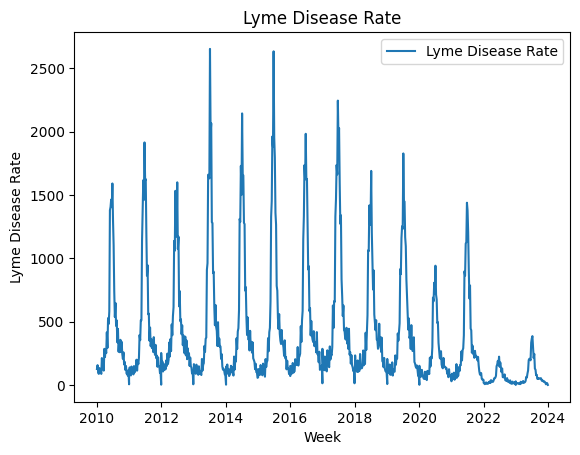

In [14]:
plt.plot(lyme_disease_rate['Cases'], label='Lyme Disease Rate')
plt.xlabel('Week')
plt.ylabel('Lyme Disease Rate')
plt.legend()
plt.title('Lyme Disease Rate')
plt.show();

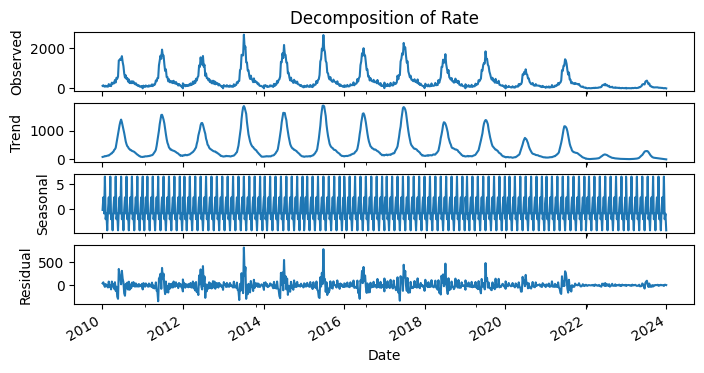

In [15]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomp1 = seasonal_decompose(lyme_disease_rate['Cases'], period=7, model='additive', extrapolate_trend='freq')
decomp2 = seasonal_decompose(lyme_disease_rate['Cases'], period=14, model='additive', extrapolate_trend='freq')
decomp3 = seasonal_decompose(lyme_disease_rate['Cases'], period=28, model='additive', extrapolate_trend='freq')

fig, ax = plt.subplots(ncols=1, nrows=4, sharex=True, figsize=(8,4))
ax[0].set_title('Decomposition of Rate')
decomp1.observed.plot(ax=ax[0], legend=False)
ax[0].set_ylabel('Observed')

decomp1.trend.plot(ax=ax[1], legend=False)
ax[1].set_ylabel('Trend')

decomp1.seasonal.plot(ax=ax[2], legend=False)
ax[2].set_ylabel('Seasonal')

decomp1.resid.plot(ax=ax[3], legend=False)
ax[3].set_ylabel('Residual')

plt.show();

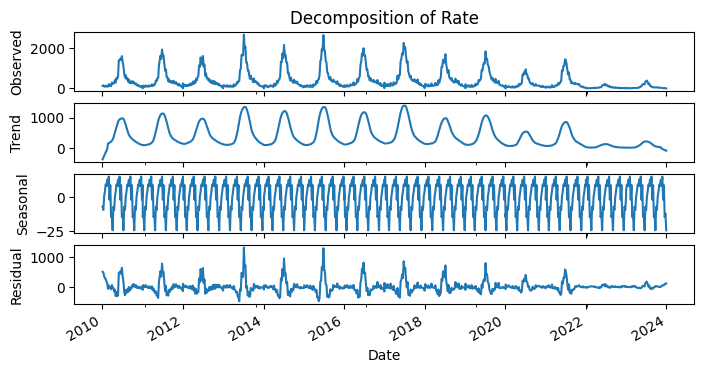

In [16]:
fig, ax = plt.subplots(ncols=1, nrows=4, sharex=True, figsize=(8,4))
ax[0].set_title('Decomposition of Rate')
decomp2.observed.plot(ax=ax[0], legend=False)
ax[0].set_ylabel('Observed')

decomp2.trend.plot(ax=ax[1], legend=False)
ax[1].set_ylabel('Trend')

decomp2.seasonal.plot(ax=ax[2], legend=False)
ax[2].set_ylabel('Seasonal')

decomp2.resid.plot(ax=ax[3], legend=False)
ax[3].set_ylabel('Residual')

plt.show();

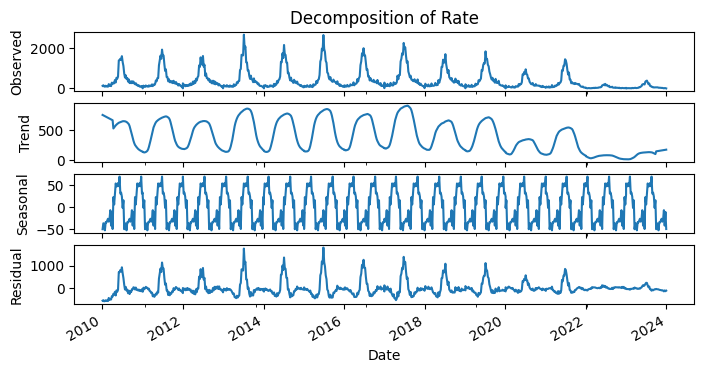

In [17]:
fig, ax = plt.subplots(ncols=1, nrows=4, sharex=True, figsize=(8,4))
ax[0].set_title('Decomposition of Rate')
decomp3.observed.plot(ax=ax[0], legend=False)
ax[0].set_ylabel('Observed')

decomp3.trend.plot(ax=ax[1], legend=False)
ax[1].set_ylabel('Trend')

decomp3.seasonal.plot(ax=ax[2], legend=False)
ax[2].set_ylabel('Seasonal')

decomp3.resid.plot(ax=ax[3], legend=False)
ax[3].set_ylabel('Residual')

plt.show();

Analysis of Decomposition Plots: There is a clear pattern in the seasonal decomposition of lyme disease cases across various periods. For this data we tested periods which were multiples of 7 (7, 14, 28), representing seasonal patterns across weeks. The pattern present in the seasonal decomposition indicates that a time series analysis is a good way of identifying trends in the data, and could be a good option to use for future lyme disease case prediction.

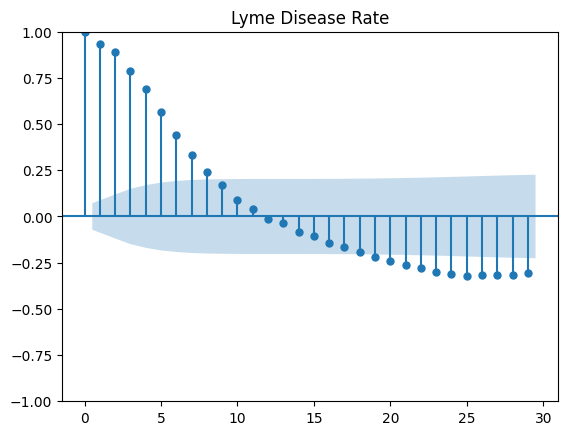

In [18]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

series = lyme_disease_rate['Cases']
plot_acf(series, title = 'Lyme Disease Rate')
plt.show();

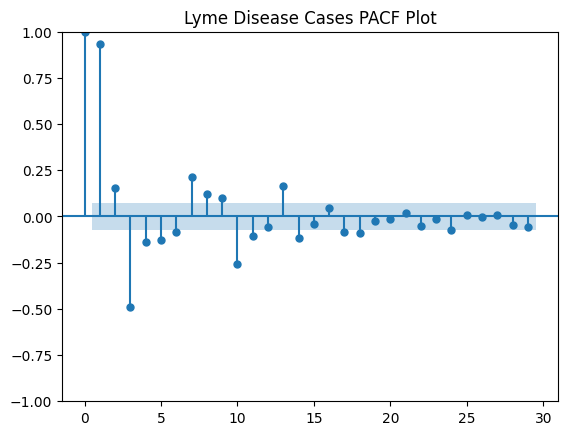

In [19]:
plot_pacf(series, title = 'Lyme Disease Cases PACF Plot')
plt.show();

In [20]:
train_size = int(.8 * len(lyme_disease_rate))
train_data = lyme_disease_rate[:train_size]
test_data = lyme_disease_rate[train_size:]

# put the y feature in arrays
y_train = np.array(train_data['Cases']).reshape(-1,1)
y_test = np.array(test_data['Cases']).reshape(-1,1)

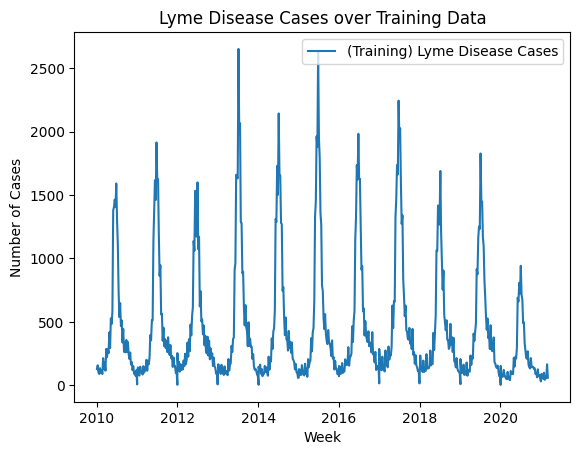

In [21]:
plt.plot(train_data['Cases'], label='(Training) Lyme Disease Cases')
plt.xlabel('Week')
plt.ylabel('Number of Cases')
plt.legend()
plt.title('Lyme Disease Cases over Training Data')
plt.show();

In [22]:
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.api import AutoReg

ar_model = AutoReg(y_train, lags=8, trend='n')
ar_results = ar_model.fit()

In [23]:
ar_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            AutoReg Model Results                             
==============================================================================
Dep. Variable:                      y   No. Observations:                  593
Model:                     AutoReg(8)   Log Likelihood               -3758.938
Method:               Conditional MLE   S.D. of innovations            149.395
Date:                Sun, 13 Apr 2025   AIC                           7535.876
Time:                        23:45:46   BIC                           7575.221
Sample:                             8   HQIC                          7551.210
                                  593                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
y.L1           0.7768      0.041     18.996      0.000       0.697       0.857
y.L2           0.6385      0.052     12.344      0.000       0.537       0.740
y.L3          -0.2966      0.057     -5.249      0.000      -0.407      -0.186
y.L4           0.0504      0.057      0.877      0.380      -0.062       0.163
y.L5          -0.1683      0.057     -2.932      0.003      -0.281      -0.056
y.L6          -0.3235      0.057     -5.725      0.000      -0.434      -0.213
y.L7           0.1364      0.052      2.638      0.008       0.035       0.238
y.L8           0.1488      0.041      3.638      0.000       0.069       0.229
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0490           -0.0000j            1.0490           -0.0000
AR.2            1.0665           -0.3729j            1.1298           -0.0535
AR.3            1.0665           +0.3729j            1.1298            0.0535
AR.4            0.0422           -1.2446j            1.2453           -0.2446
AR.5            0.0422           +1.2446j            1.2453            0.2446
AR.6           -1.2918           -0.5955j            1.4225           -0.4313
AR.7           -1.2918           +0.5955j            1.4225            0.4313
AR.8           -1.5996           -0.0000j            1.5996           -0.5000
-----------------------------------------------------------------------------
"""

In [25]:
ar_pred = ar_results.predict(start=len(train_data), end=len(train_data) + len(test_data) - 1)
pred_data_ar = pd.DataFrame({'Data': test_data.index, 'pred Cases': ar_pred.flatten()})
pred_data_ar.set_index('Data', inplace = True)
pred_data_ar.head()

,pred Cases
Data,
2021-03-14,115.112825
2021-03-21,78.310617
2021-03-28,116.771059
2021-04-04,77.621058
2021-04-11,70.663804


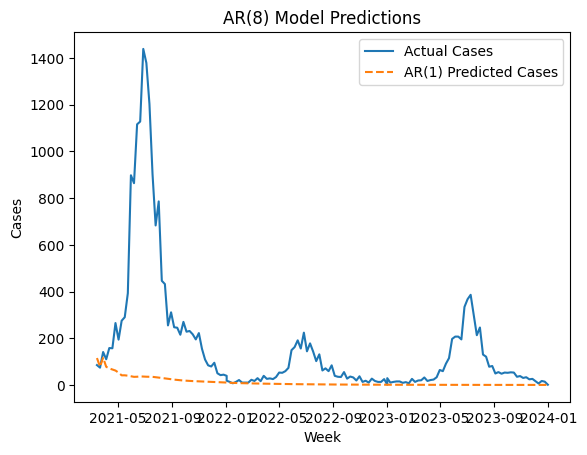

In [27]:
plt.plot(test_data['Cases'], label = 'Actual Cases')
plt.plot(pred_data_ar['pred Cases'], label = 'AR(1) Predicted Cases', linestyle = '--')
plt.xlabel('Week')
plt.ylabel('Cases')
plt.legend()
plt.title('AR(8) Model Predictions')
plt.show();

In [28]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

mae = mean_absolute_error(y_test, ar_pred)
rmse = np.sqrt(mean_squared_error(y_test, ar_pred))
print(f'Mean Absolute Error: {mae:.2f}')
print(f'Root Mean Squared Error: {rmse:.2f}')

Mean Absolute Error: 149.75
Root Mean Squared Error: 296.23


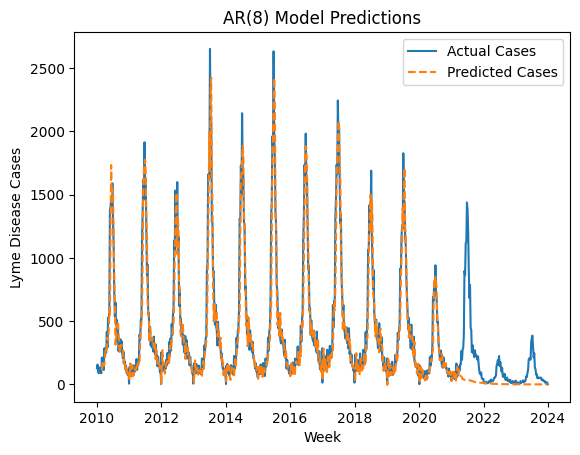

In [29]:
ar_pred_full = ar_results.predict(start=0, end=len(train_data) + len(test_data) - 1) # note we start at zero

plt.plot(lyme_disease_rate['Cases'], label = 'Actual Cases')
plt.plot(lyme_disease_rate.index, ar_pred_full, label = 'Predicted Cases', linestyle = '--')
plt.xlabel('Week')
plt.ylabel('Lyme Disease Cases')
plt.legend()
plt.title('AR(8) Model Predictions')
plt.show();

In [30]:
ar_model_14 = AutoReg(y_train, lags=14, trend='n')
ar_results_14 = ar_model_14.fit()

In [31]:
ar_results_14.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            AutoReg Model Results                             
==============================================================================
Dep. Variable:                      y   No. Observations:                  593
Model:                    AutoReg(14)   Log Likelihood               -3684.099
Method:               Conditional MLE   S.D. of innovations            140.320
Date:                Sun, 13 Apr 2025   AIC                           7398.198
Time:                        23:48:04   BIC                           7463.618
Sample:                            14   HQIC                          7423.705
                                  593                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
y.L1           0.7891      0.041     19.048      0.000       0.708       0.870
y.L2           0.6555      0.052     12.709      0.000       0.554       0.757
y.L3          -0.2031      0.058     -3.498      0.000      -0.317      -0.089
y.L4          -0.0822      0.058     -1.418      0.156      -0.196       0.031
y.L5          -0.2469      0.058     -4.270      0.000      -0.360      -0.134
y.L6          -0.2708      0.057     -4.738      0.000      -0.383      -0.159
y.L7           0.0621      0.058      1.079      0.281      -0.051       0.175
y.L8           0.2113      0.058      3.669      0.000       0.098       0.324
y.L9           0.3230      0.057      5.652      0.000       0.211       0.435
y.L10         -0.1239      0.058     -2.143      0.032      -0.237      -0.011
y.L11         -0.2233      0.058     -3.854      0.000      -0.337      -0.110
y.L12         -0.1250      0.058     -2.152      0.031      -0.239      -0.011
y.L13          0.2788      0.052      5.410      0.000       0.178       0.380
y.L14         -0.0828      0.041     -2.000      0.046      -0.164      -0.002
                                    Roots                                     
==============================================================================
                   Real          Imaginary           Modulus         Frequency
------------------------------------------------------------------------------
AR.1            -1.0246           -0.2560j            1.0560           -0.4610
AR.2            -1.0246           +0.2560j            1.0560            0.4610
AR.3            -0.8961           -0.7322j            1.1572           -0.3910
AR.4            -0.8961           +0.7322j            1.1572            0.3910
AR.5            -0.4323           -1.0563j            1.1414           -0.3118
AR.6            -0.4323           +1.0563j            1.1414            0.3118
AR.7             0.1663           -1.0520j            1.0651           -0.2250
AR.8             0.1663           +1.0520j            1.0651            0.2250
AR.9             1.0621           -0.0000j            1.0621           -0.0000
AR.10            1.0948           -0.6400j            1.2681           -0.0842
AR.11            1.0948           +0.6400j            1.2681            0.0842
AR.12            1.1629           -0.3595j            1.2172           -0.0477
AR.13            1.1629           +0.3595j            1.2172            0.0477
AR.14            2.1630           -0.0000j            2.1630           -0.0000
------------------------------------------------------------------------------
"""

In [32]:
ar_pred_14 = ar_results_14.predict(start=len(train_data), end=len(train_data) + len(test_data) - 1)
pred_data_14 = pd.DataFrame({'Data': test_data.index, 'pred Cases': ar_pred_14.flatten()})
pred_data_14.set_index('Data', inplace = True)
pred_data_14.head()

,pred Cases
Data,
2021-03-14,140.398223
2021-03-21,102.779257
2021-03-28,123.040905
2021-04-04,104.518688
2021-04-11,88.609481


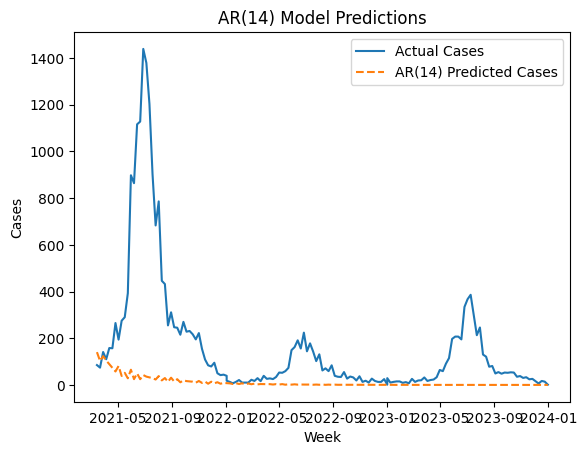

In [34]:
plt.plot(test_data['Cases'], label = 'Actual Cases')
plt.plot(pred_data_14['pred Cases'], label = 'AR(14) Predicted Cases', linestyle = '--')
plt.xlabel('Week')
plt.ylabel('Cases')
plt.legend()
plt.title('AR(14) Model Predictions')
plt.show();

In [36]:
mae = mean_absolute_error(y_test, ar_pred_14)
rmse = np.sqrt(mean_squared_error(y_test, ar_pred_14))
print(f'Mean Absolute Error: {mae:.2f}')
print(f'Root Mean Squared Error: {rmse:.2f}')

Mean Absolute Error: 150.50
Root Mean Squared Error: 296.18


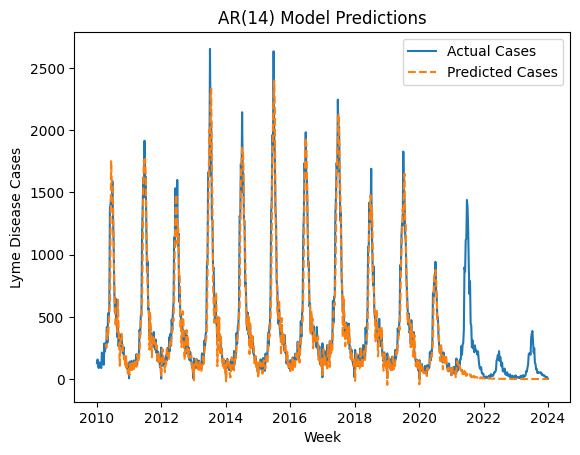

In [37]:
ar_pred_full_14 = ar_results_14.predict(start=0, end=len(train_data) + len(test_data) - 1) # note we start at zero

plt.plot(lyme_disease_rate['Cases'], label = 'Actual Cases')
plt.plot(lyme_disease_rate.index, ar_pred_full_14, label = 'Predicted Cases', linestyle = '--')
plt.xlabel('Week')
plt.ylabel('Lyme Disease Cases')
plt.legend()
plt.title('AR(14) Model Predictions')
plt.show();

In [38]:
ar_model_35 = AutoReg(y_train, lags=35, trend='n')
ar_results_35 = ar_model_35.fit()

In [39]:
ar_results_35.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            AutoReg Model Results                             
==============================================================================
Dep. Variable:                      y   No. Observations:                  593
Model:                    AutoReg(35)   Log Likelihood               -3524.148
Method:               Conditional MLE   S.D. of innovations            133.853
Date:                Mon, 14 Apr 2025   AIC                           7120.296
Time:                        00:33:05   BIC                           7275.973
Sample:                            35   HQIC                          7181.093
                                  593                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
y.L1           0.7729      0.042     18.314      0.000       0.690       0.856
y.L2           0.6984      0.053     13.088      0.000       0.594       0.803
y.L3          -0.2366      0.061     -3.886      0.000      -0.356      -0.117
y.L4          -0.0828      0.062     -1.344      0.179      -0.204       0.038
y.L5          -0.2383      0.062     -3.868      0.000      -0.359      -0.118
y.L6          -0.2688      0.062     -4.314      0.000      -0.391      -0.147
y.L7           0.0472      0.063      0.747      0.455      -0.077       0.171
y.L8           0.2053      0.063      3.251      0.001       0.082       0.329
y.L9           0.3241      0.064      5.094      0.000       0.199       0.449
y.L10         -0.0911      0.065     -1.402      0.161      -0.219       0.036
y.L11         -0.2171      0.065     -3.332      0.001      -0.345      -0.089
y.L12         -0.1685      0.066     -2.569      0.010      -0.297      -0.040
y.L13          0.3236      0.066      4.921      0.000       0.195       0.452
y.L14         -0.1524      0.066     -2.295      0.022      -0.283      -0.022
y.L15         -0.0264      0.066     -0.401      0.688      -0.156       0.103
y.L16          0.1747      0.066      2.663      0.008       0.046       0.303
y.L17         -0.0649      0.066     -0.985      0.325      -0.194       0.064
y.L18         -0.0857      0.066     -1.305      0.192      -0.214       0.043
y.L19         -0.0274      0.066     -0.418      0.676      -0.156       0.101
y.L20          0.0567      0.065      0.871      0.384      -0.071       0.184
y.L21          0.0967      0.065      1.484      0.138      -0.031       0.224
y.L22         -0.0511      0.065     -0.785      0.432      -0.179       0.076
y.L23         -0.0429      0.064     -0.672      0.502      -0.168       0.082
y.L24         -0.0671      0.063     -1.058      0.290      -0.191       0.057
y.L25          0.0387      0.063      0.616      0.538      -0.084       0.162
y.L26          0.0234      0.063      0.373      0.709      -0.100       0.146
y.L27          0.0993      0.061      1.627      0.104      -0.020       0.219
y.L28         -0.0239      0.061     -0.394      0.694      -0.143       0.095
y.L29         -0.1131      0.061     -1.865      0.062      -0.232       0.006
y.L30         -0.0182      0.060     -0.305      0.760      -0.136       0.099
y.L31          0.0576      0.059      0.975      0.330      -0.058       0.173
y.L32          0.0800      0.059      1.356      0.175      -0.036       0.196
y.L33         -0.0494      0.058     -0.846      0.398      -0.164       0.065
y.L34         -0.0477      0.051     -0.927      0.354      -0.149       0.053
y.L35          0.0489      0.041      1.205      0.228      -0.031       0.128
                                    Roots                                     
==============================================================================
                   Real          Imaginary           Modulus         Frequency
--

In [40]:
ar_pred_35 = ar_results_35.predict(start=len(train_data), end=len(train_data) + len(test_data) - 1)
pred_data_35 = pd.DataFrame({'Data': test_data.index, 'pred Cases': ar_pred_35.flatten()})
pred_data_35.set_index('Data', inplace = True)
pred_data_35.head()

,pred Cases
Data,
2021-03-14,143.893099
2021-03-21,105.744043
2021-03-28,137.056968
2021-04-04,134.323693
2021-04-11,132.969807


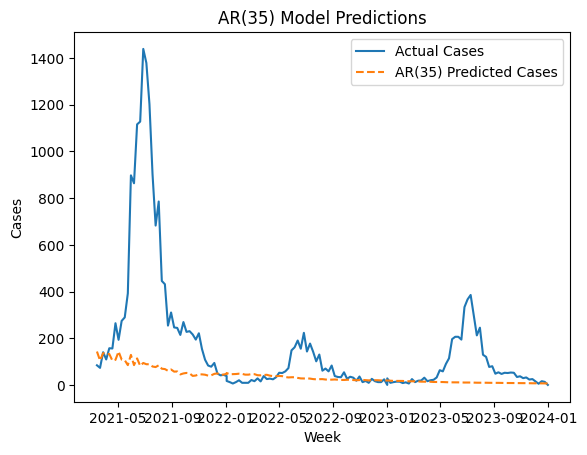

In [41]:
plt.plot(test_data['Cases'], label = 'Actual Cases')
plt.plot(pred_data_35['pred Cases'], label = 'AR(35) Predicted Cases', linestyle = '--')
plt.xlabel('Week')
plt.ylabel('Cases')
plt.legend()
plt.title('AR(35) Model Predictions')
plt.show();

In [42]:
mae = mean_absolute_error(y_test, ar_pred_35)
rmse = np.sqrt(mean_squared_error(y_test, ar_pred_35))
print(f'Mean Absolute Error: {mae:.2f}')
print(f'Root Mean Squared Error: {rmse:.2f}')

Mean Absolute Error: 131.55
Root Mean Squared Error: 276.44


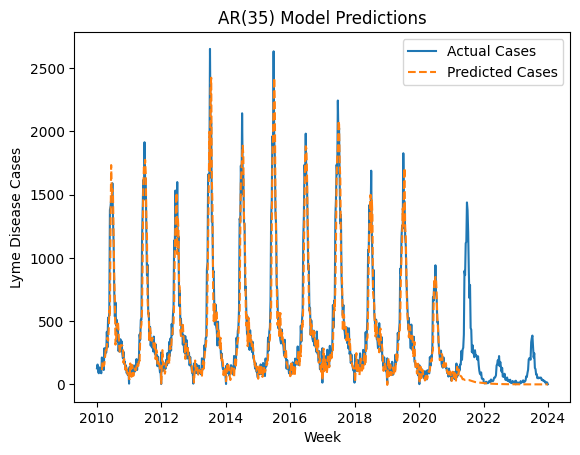

In [43]:
ar_pred_full_35 = ar_results.predict(start=0, end=len(train_data) + len(test_data) - 1) # note we start at zero

plt.plot(lyme_disease_rate['Cases'], label = 'Actual Cases')
plt.plot(lyme_disease_rate.index, ar_pred_full_35, label = 'Predicted Cases', linestyle = '--')
plt.xlabel('Week')
plt.ylabel('Lyme Disease Cases')
plt.legend()
plt.title('AR(35) Model Predictions')
plt.show();

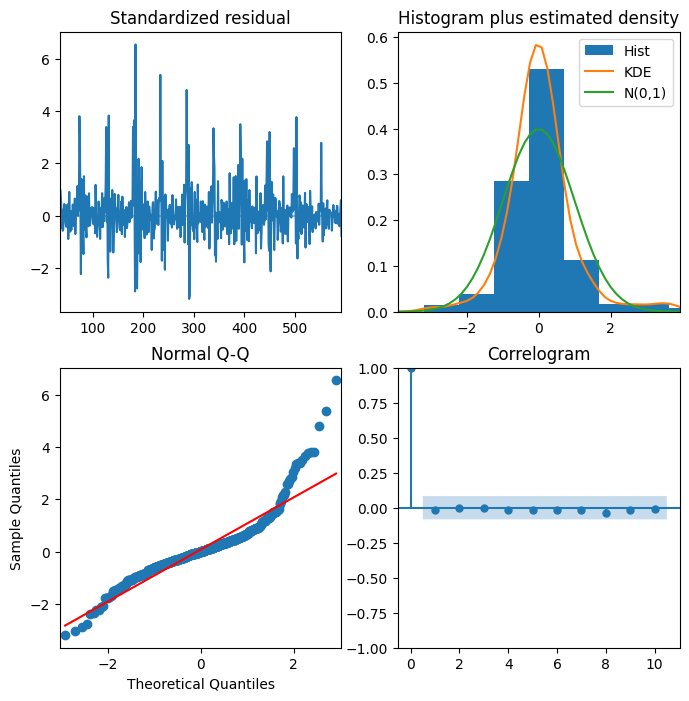

In [44]:
ar_results_35.plot_diagnostics(figsize=(8,8));

In [45]:
from statsmodels.tsa.arima.model import ARIMA

In [46]:
ma_model = ARIMA(y_train, order=(0, 0, 8))
ma_results = ma_model.fit()
ma_results.summary()

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  593
Model:                 ARIMA(0, 0, 8)   Log Likelihood               -3815.057
Date:                Mon, 14 Apr 2025   AIC                           7650.115
Time:                        00:36:31   BIC                           7693.967
Sample:                             0   HQIC                          7667.194
                                - 593                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        440.5801     70.339      6.264      0.000     302.718     578.442
ma.L1          0.7555      0.032     23.410      0.000       0.692       0.819
ma.L2          1.1518      0.041     27.792      0.000       1.071       1.233
ma.L3          0.9591      0.056     17.021      0.000       0.849       1.070
ma.L4          1.1504      0.051     22.451      0.000       1.050       1.251
ma.L5          0.8654      0.062     13.941      0.000       0.744       0.987
ma.L6          0.7125      0.060     11.921      0.000       0.595       0.830
ma.L7          0.3086      0.045      6.786      0.000       0.219       0.398
ma.L8          0.1458      0.040      3.671      0.000       0.068       0.224
sigma2      2.254e+04    913.563     24.673      0.000    2.08e+04    2.43e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.46   Jarque-Bera (JB):              3631.89
Prob(Q):                              0.50   Prob(JB):                         0.00
Heteroskedasticity (H):               0.59   Skew:                             2.66
Prob(H) (two-sided):                  0.00   Kurtosis:                        13.90
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [47]:
abs(ma_results.maroots)

array([1.05888744, 1.05888744, 1.35673516, 1.35673516, 1.31114768,
       1.31114768, 1.39039129, 1.39039129])

In [48]:
ma_pred = ma_results.predict(start=len(train_data), end=len(train_data) + len(test_data) - 1)
pred_data_ma = pd.DataFrame({'Date': test_data.index, 'pred Cases': ma_pred.flatten()})
pred_data_ma.set_index('Date', inplace = True)
pred_data_ma.head()

,pred Cases
Date,
2021-03-14,182.596134
2021-03-21,184.897660
2021-03-28,294.356986
2021-04-04,302.381091
2021-04-11,361.672738


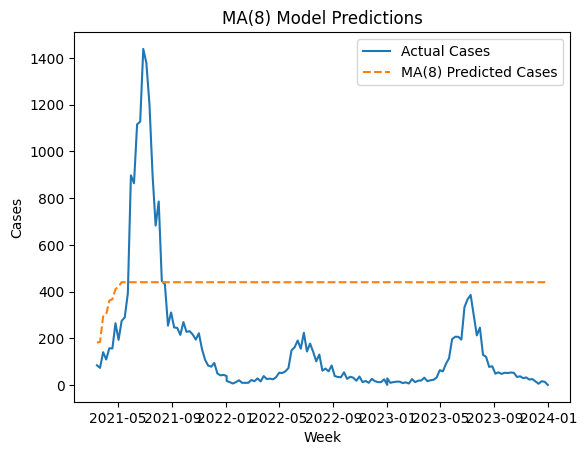

In [49]:
plt.plot(test_data['Cases'], label = 'Actual Cases')
plt.plot(pred_data_ma['pred Cases'], label = 'MA(8) Predicted Cases', linestyle = '--')
plt.xlabel('Week')
plt.ylabel('Cases')
plt.legend()
plt.title('MA(8) Model Predictions')
plt.show();

In [50]:
mae = mean_absolute_error(y_test, ma_pred)
rmse = np.sqrt(mean_squared_error(y_test, ma_pred))
print(f'Mean Absolute Error: {mae:.2f}')
print(f'Root Mean Squared Error: {rmse:.2f}')

Mean Absolute Error: 353.70
Root Mean Squared Error: 380.12


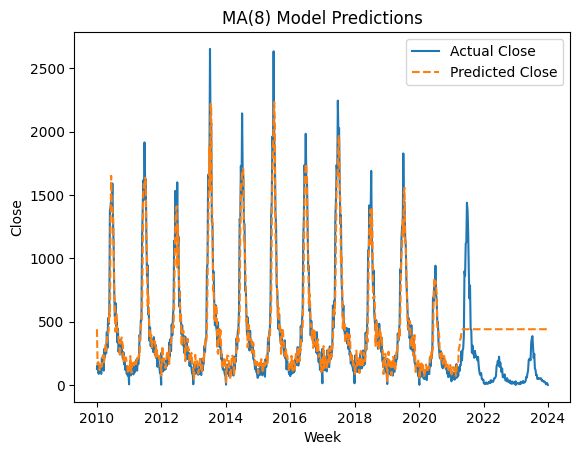

In [51]:
ma_pred_full = ma_results.predict(start=0, end=len(train_data) + len(test_data) - 1) # note we start at zero

plt.plot(lyme_disease_rate['Cases'], label = 'Actual Close')
plt.plot(lyme_disease_rate.index, ma_pred_full, label = 'Predicted Close', linestyle = '--')
plt.xlabel('Week')
plt.ylabel('Close')
plt.legend()
plt.title('MA(8) Model Predictions')
plt.show();

In [52]:
ma_model_35 = ARIMA(y_train, order=(0, 0, 35))
ma_results_35 = ma_model_35.fit()
ma_results_35.summary()

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  593
Model:                ARIMA(0, 0, 35)   Log Likelihood               -3813.251
Date:                Mon, 14 Apr 2025   AIC                           7700.503
Time:                        00:39:15   BIC                           7862.755
Sample:                             0   HQIC                          7763.697
                                - 593                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        440.9126     21.302     20.698      0.000     399.161     482.665
ma.L1          0.7140      4.427      0.161      0.872      -7.962       9.390
ma.L2          1.1198      7.291      0.154      0.878     -13.170      15.410
ma.L3          1.0650     11.638      0.092      0.927     -21.746      23.876
ma.L4          1.2508     15.180      0.082      0.934     -28.502      31.003
ma.L5          1.0186     18.789      0.054      0.957     -35.806      37.844
ma.L6          0.7253     20.506      0.035      0.972     -39.466      40.917
ma.L7          0.3487     20.063      0.017      0.986     -38.973      39.671
ma.L8         -0.0414     17.061     -0.002      0.998     -33.479      33.397
ma.L9         -0.1750     11.559     -0.015      0.988     -22.830      22.480
ma.L10        -0.4692      5.030     -0.093      0.926     -10.328       9.389
ma.L11        -0.5909      2.995     -0.197      0.844      -6.460       5.278
ma.L12        -0.8032     11.375     -0.071      0.944     -23.097      21.491
ma.L13        -0.4400     20.233     -0.022      0.983     -40.095      39.215
ma.L14        -0.5396     26.566     -0.020      0.984     -52.608      51.529
ma.L15        -0.2344     32.213     -0.007      0.994     -63.370      62.901
ma.L16        -0.1275     35.191     -0.004      0.997     -69.101      68.846
ma.L17        -0.0018     36.273  -4.91e-05      1.000     -71.097      71.093
ma.L18         0.4654     35.288      0.013      0.989     -68.698      69.629
ma.L19         0.5564     30.794      0.018      0.986     -59.799      60.912
ma.L20         0.8781     24.751      0.035      0.972     -47.634      49.390
ma.L21         0.8299     16.331      0.051      0.959     -31.179      32.839
ma.L22         0.7540      7.501      0.101      0.920     -13.947      15.455
ma.L23         0.5953      1.296      0.459      0.646      -1.945       3.136
ma.L24         0.3967      9.100      0.044      0.965     -17.440      18.233
ma.L25        -0.1017     15.670     -0.006      0.995     -30.813      30.610
ma.L26        -0.4400     19.405     -0.023      0.982     -38.473      37.593
ma.L27        -0.7820     20.853     -0.038      0.970     -41.652      40.088
ma.L28        -0.8868     19.945     -0.044      0.965     -39.977      38.204
ma.L29        -1.0063     17.854     -0.056      0.955     -35.999      33.986
ma.L30        -1.1112     14.629     -0.076      0.939     -29.784      27.562
ma.L31        -0.8919     10.413     -0.086      0.932     -21.301      19.517
ma.L32        -0.5446      6.819     -0.080      0.936     -13.909      12.820
ma.L33        -0.4219      4.597     -0.092      0.927      -9.432       8.588
ma.L34        -0.3220      2.800     -0.115      0.908      -5.810       5.166
ma.L35        -0.2967      1.368     -0.217      0.828      -2.978       2.385
sigma2      2.288e+04   1.05e+05      0.218      0.828   -1.83e+05    2.29e+05
=================================================================================

In [53]:
abs(ma_results_35.maroots)

array([1.05888744, 1.05888744, 1.35673516, 1.35673516, 1.31114768,
       1.31114768, 1.39039129, 1.39039129])

In [54]:
ma_pred_35 = ma_results_35.predict(start=len(train_data), end=len(train_data) + len(test_data) - 1)
pred_data_35 = pd.DataFrame({'Date': test_data.index, 'pred Cases': ma_pred_35.flatten()})
pred_data_35.set_index('Date', inplace = True)
pred_data_35.head()

,pred Cases
Date,
2021-03-14,190.604760
2021-03-21,151.553836
2021-03-28,318.808531
2021-04-04,470.356935
2021-04-11,486.530842


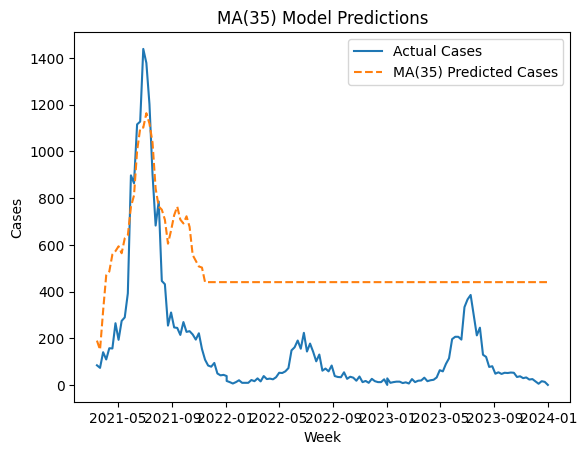

In [55]:
plt.plot(test_data['Cases'], label = 'Actual Cases')
plt.plot(pred_data_35['pred Cases'], label = 'MA(35) Predicted Cases', linestyle = '--')
plt.xlabel('Week')
plt.ylabel('Cases')
plt.legend()
plt.title('MA(35) Model Predictions')
plt.show();

In [56]:
mae = mean_absolute_error(y_test, ma_pred_35)
rmse = np.sqrt(mean_squared_error(y_test, ma_pred_35))
print(f'Mean Absolute Error: {mae:.2f}')
print(f'Root Mean Squared Error: {rmse:.2f}')

Mean Absolute Error: 350.99
Root Mean Squared Error: 366.21


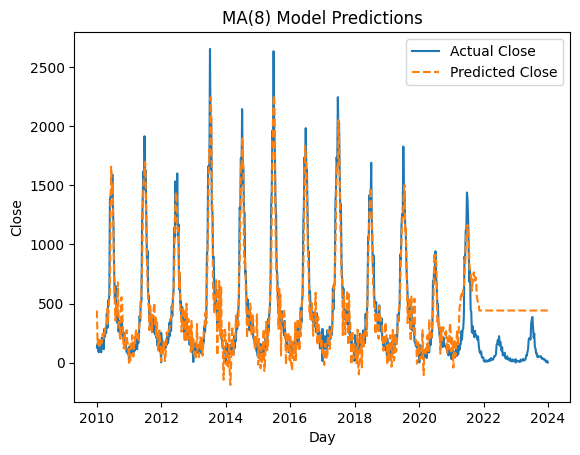

In [57]:
ma_pred_full_35 = ma_results_35.predict(start=0, end=len(train_data) + len(test_data) - 1) # note we start at zero

plt.plot(lyme_disease_rate['Cases'], label = 'Actual Close')
plt.plot(lyme_disease_rate.index, ma_pred_full_35, label = 'Predicted Close', linestyle = '--')
plt.xlabel('Week')
plt.ylabel('Case')
plt.legend()
plt.title('MA(35) Model Predictions')
plt.show();

In [58]:
arma_model = ARIMA(y_train, order=(8, 0, 8)) 
arma_results = arma_model.fit()
arma_results.summary()

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  593
Model:                 ARIMA(8, 0, 8)   Log Likelihood               -3760.256
Date:                Mon, 14 Apr 2025   AIC                           7556.512
Time:                        00:42:26   BIC                           7635.445
Sample:                             0   HQIC                          7587.255
                                - 593                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        440.6219     91.984      4.790      0.000     260.336     620.908
ar.L1          0.1978      0.639      0.310      0.757      -1.054       1.450
ar.L2          0.3019      0.468      0.645      0.519      -0.615       1.219
ar.L3         -0.2670      0.265     -1.008      0.313      -0.786       0.252
ar.L4          0.8063      0.230      3.501      0.000       0.355       1.258
ar.L5         -0.0340      0.391     -0.087      0.931      -0.800       0.732
ar.L6         -0.4368      0.362     -1.206      0.228      -1.147       0.273
ar.L7          0.1900      0.316      0.602      0.547      -0.429       0.809
ar.L8         -0.1563      0.259     -0.604      0.546      -0.663       0.351
ma.L1          0.5423      0.644      0.842      0.400      -0.719       1.804
ma.L2          0.7644      0.828      0.923      0.356      -0.859       2.388
ma.L3          0.9954      0.834      1.194      0.232      -0.639       2.629
ma.L4          0.2460      0.990      0.249      0.804      -1.694       2.186
ma.L5          0.4625      0.776      0.596      0.551      -1.058       1.983
ma.L6          0.3194      0.519      0.616      0.538      -0.697       1.336
ma.L7         -0.0824      0.480     -0.172      0.864      -1.022       0.858
ma.L8         -0.0411      0.283     -0.145      0.884      -0.596       0.514
sigma2      1.839e+04    807.125     22.785      0.000    1.68e+04       2e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              1542.03
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               0.50   Skew:                             1.73
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.10
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [59]:
abs(arma_results.maroots)

array([1.03557766, 1.03557766, 1.1417948 , 1.1417948 , 2.85503743,
       1.35299233, 1.35299233, 3.32660983])

In [62]:
arma_pred = arma_results.predict(start=len(train_data), end=len(train_data) + len(test_data) - 1)
pred_data_arma = pd.DataFrame({'Date': test_data.index, 'pred Cases': arma_pred.flatten()})
pred_data_arma.set_index('Date', inplace = True)
pred_data_arma.head()

,pred Cases
Date,
2021-03-14,200.390357
2021-03-21,178.397732
2021-03-28,243.989822
2021-04-04,268.590451
2021-04-11,317.484854


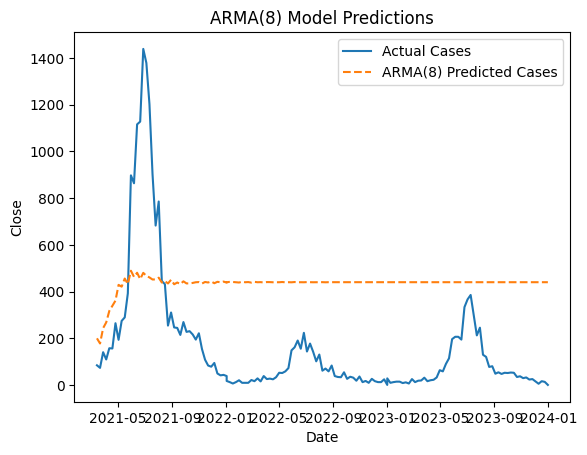

In [63]:
plt.plot(test_data['Cases'], label = 'Actual Cases')
plt.plot(pred_data_arma['pred Cases'], label = 'ARMA(8) Predicted Cases', linestyle = '--')
plt.xlabel('Date')
plt.ylabel('Close')
plt.legend()
plt.title('ARMA(8) Model Predictions')
plt.show();

In [64]:
mae = mean_absolute_error(y_test, arma_pred)
rmse = np.sqrt(mean_squared_error(y_test, arma_pred))
print(f'Mean Absolute Error: {mae:.2f}')
print(f'Root Mean Squared Error: {rmse:.2f}')

Mean Absolute Error: 350.56
Root Mean Squared Error: 376.67


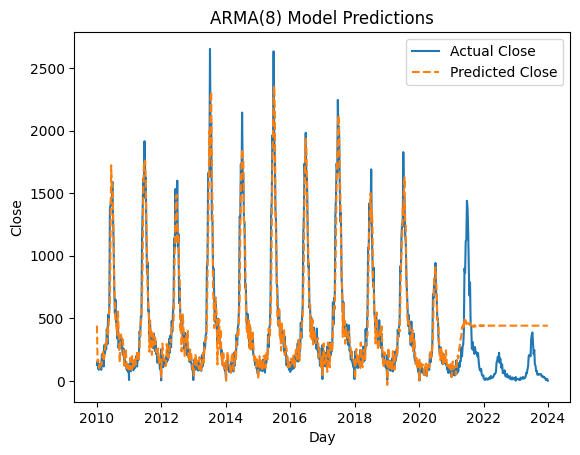

In [65]:
arma_pred_full = arma_results.predict(start=0, end=len(train_data) + len(test_data) - 1) # note we start at zero

plt.plot(lyme_disease_rate['Cases'], label = 'Actual Close')
plt.plot(lyme_disease_rate.index, arma_pred_full, label = 'Predicted Close', linestyle = '--')
plt.xlabel('Week')
plt.ylabel('Cases')
plt.legend()
plt.title('ARMA(8) Model Predictions')
plt.show();

In [66]:
arma_model_21 = ARIMA(y_train, order=(21, 0, 21)) 
arma_results_21 = arma_model_21.fit()
arma_results_21.summary()

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  593
Model:               ARIMA(21, 0, 21)   Log Likelihood               -3708.507
Date:                Mon, 14 Apr 2025   AIC                           7505.014
Time:                        00:45:57   BIC                           7697.963
Sample:                             0   HQIC                          7580.165
                                - 593                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        440.6277     31.245     14.103      0.000     379.390     501.866
ar.L1         -0.5105      0.163     -3.132      0.002      -0.830      -0.191
ar.L2          0.0793      0.121      0.656      0.512      -0.158       0.316
ar.L3          0.4894      0.098      5.007      0.000       0.298       0.681
ar.L4          0.7643      0.087      8.753      0.000       0.593       0.935
ar.L5          0.3637      0.148      2.457      0.014       0.074       0.654
ar.L6          0.1475      0.108      1.364      0.173      -0.064       0.360
ar.L7         -0.0040      0.107     -0.038      0.970      -0.215       0.206
ar.L8         -0.2854      0.099     -2.895      0.004      -0.479      -0.092
ar.L9         -0.1646      0.095     -1.725      0.085      -0.352       0.022
ar.L10         0.1244      0.081      1.535      0.125      -0.034       0.283
ar.L11         0.2378      0.069      3.425      0.001       0.102       0.374
ar.L12        -0.3744      0.072     -5.184      0.000      -0.516      -0.233
ar.L13        -0.5051      0.092     -5.480      0.000      -0.686      -0.324
ar.L14        -0.3808      0.100     -3.816      0.000      -0.576      -0.185
ar.L15        -0.1481      0.122     -1.210      0.226      -0.388       0.092
ar.L16         0.3848      0.099      3.903      0.000       0.192       0.578
ar.L17         0.5713      0.092      6.185      0.000       0.390       0.752
ar.L18         0.2519      0.089      2.834      0.005       0.078       0.426
ar.L19         0.1299      0.082      1.578      0.115      -0.031       0.291
ar.L20        -0.5360      0.066     -8.130      0.000      -0.665      -0.407
ar.L21        -0.2696      0.104     -2.601      0.009      -0.473      -0.066
ma.L1          1.1623      0.167      6.948      0.000       0.834       1.490
ma.L2          1.3413      0.222      6.030      0.000       0.905       1.777
ma.L3          0.9675      0.305      3.173      0.002       0.370       1.565
ma.L4          0.4978      0.273      1.826      0.068      -0.037       1.032
ma.L5          0.0664      0.229      0.291      0.771      -0.382       0.515
ma.L6         -0.6016      0.181     -3.329      0.001      -0.956      -0.247
ma.L7         -1.1152      0.143     -7.812      0.000      -1.395      -0.835
ma.L8         -1.2779      0.215     -5.933      0.000      -1.700      -0.856
ma.L9         -1.0849      0.301     -3.600      0.000      -1.676      -0.494
ma.L10        -1.0220      0.336     -3.046      0.002      -1.680      -0.364
ma.L11        -0.9946      0.332     -2.994      0.003      -1.646      -0.343
ma.L12        -0.3857      0.316     -1.222      0.222      -1.004       0.233
ma.L13         0.3819      0.235      1.625      0.104      -0.079       0.843
ma.L14         0.9301      0.139      6.691      0.000       0.658       1.203
ma.L15         1.2094      0.165      7.325      0.000       0.886       1.533
ma.L16         1.0286      0.251      4.096      0.000       0.536       1.521
ma

In [67]:
abs(arma_results_21.maroots)

array([1.0038038 , 1.0038038 , 1.01877774, 1.01877774, 1.00463082,
       1.00463082, 1.1473758 , 1.1473758 , 1.02156833, 1.02156833,
       1.14712333, 1.14712333, 1.00594034, 1.00594034, 1.16145702,
       1.16145702, 1.00627462, 1.00627462, 1.00850054, 1.00850054,
       2.06163336])

In [68]:
arma_pred_21 = arma_results_21.predict(start=len(train_data), end=len(train_data) + len(test_data) - 1)
pred_data_arma_21 = pd.DataFrame({'Date': test_data.index, 'pred Cases': arma_pred_21.flatten()})
pred_data_arma_21.set_index('Date', inplace = True)
pred_data_arma_21.head()

,pred Cases
Date,
2021-03-14,185.044679
2021-03-21,240.919348
2021-03-28,312.129196
2021-04-04,371.842216
2021-04-11,424.813984


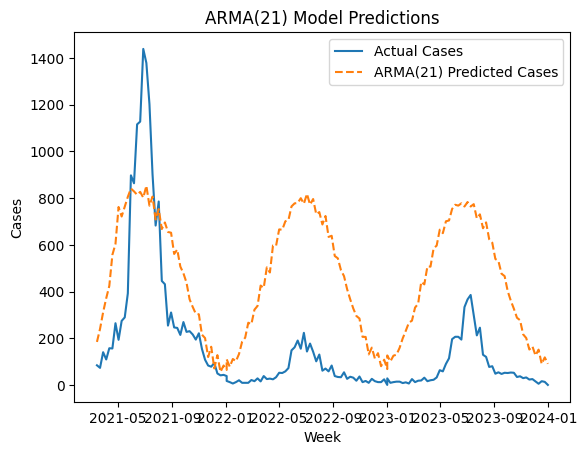

In [70]:
plt.plot(test_data['Cases'], label = 'Actual Cases')
plt.plot(pred_data_arma_21['pred Cases'], label = 'ARMA(21) Predicted Cases', linestyle = '--')
plt.xlabel('Week')
plt.ylabel('Cases')
plt.legend()
plt.title('ARMA(21) Model Predictions')
plt.show();

In [71]:
mae = mean_absolute_error(y_test, pred_data_arma_21)
rmse = np.sqrt(mean_squared_error(y_test, pred_data_arma_21))
print(f'Mean Absolute Error: {mae:.2f}')
print(f'Root Mean Squared Error: {rmse:.2f}')

Mean Absolute Error: 328.39
Root Mean Squared Error: 384.25


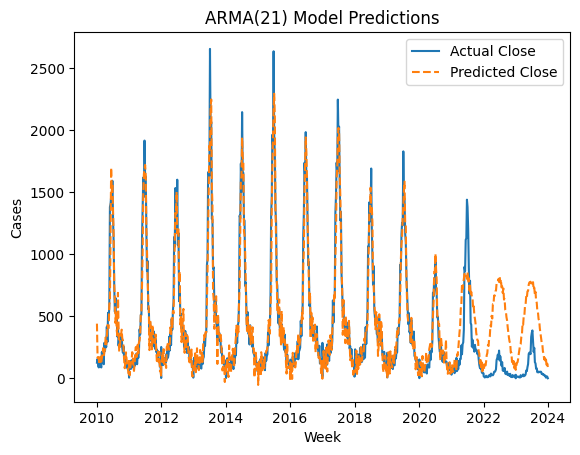

In [72]:
arma_pred_full = arma_results_21.predict(start=0, end=len(train_data) + len(test_data) - 1) # note we start at zero

plt.plot(lyme_disease_rate['Cases'], label = 'Actual Close')
plt.plot(lyme_disease_rate.index, arma_pred_full, label = 'Predicted Close', linestyle = '--')
plt.xlabel('Week')
plt.ylabel('Cases')
plt.legend()
plt.title('ARMA(21) Model Predictions')
plt.show();

In [73]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

sarima = SARIMAX(y_train, 
                 order=(7, 0, 7), 
                 seasonal_order=(1, 1, 1, 21))
results = sarima.fit()

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           17     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.12758D+01    |proj g|=  9.90362D+00

At iterate    5    f=  6.36663D+00    |proj g|=  6.55589D-02

At iterate   10    f=  6.27694D+00    |proj g|=  7.70419D-02

At iterate   15    f=  6.26255D+00    |proj g|=  5.01587D-02

At iterate   20    f=  6.25736D+00    |proj g|=  8.71750D-03

At iterate   25    f=  6.25694D+00    |proj g|=  2.38916D-03

At iterate   30    f=  6.25673D+00    |proj g|=  3.09686D-03

At iterate   35    f=  6.25546D+00    |proj g|=  2.84407D-02

At iterate   40    f=  6.25336D+00    |proj g|=  6.51112D-03

At iterate   45    f=  6.25181D+00    |proj g|=  2.35436D-02


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  6.25123D+00    |proj g|=  8.39143D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   17     50     56      1     0     0   8.391D-03   6.251D+00
  F =   6.2512270168855331     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


In [74]:
sarima_pred = results.predict(start=len(train_data), end=len(train_data) + len(test_data) - 1)
pred_data_sarima = pd.DataFrame({'Date': test_data.index, 'pred Cases': sarima_pred.flatten()})
pred_data_sarima.set_index('Date', inplace = True)
pred_data_sarima.head()

,pred Cases
Date,
2021-03-14,224.608897
2021-03-21,206.502400
2021-03-28,263.183455
2021-04-04,283.113626
2021-04-11,329.569019


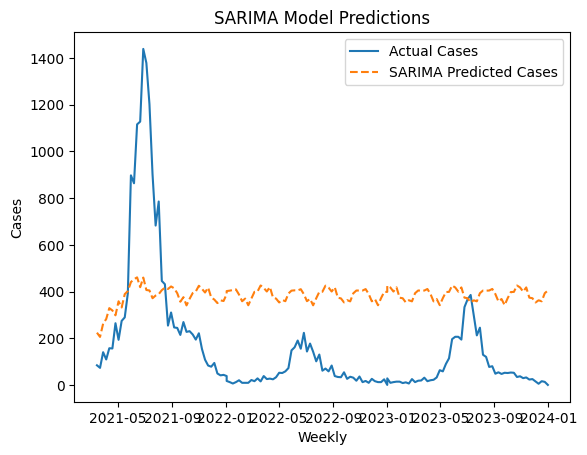

In [75]:
plt.plot(test_data['Cases'], label = 'Actual Cases')
plt.plot(pred_data_sarima['pred Cases'], label = 'SARIMA Predicted Cases', linestyle = '--')
plt.xlabel('Weekly')
plt.ylabel('Cases')
plt.legend()
plt.title('SARIMA Model Predictions')
plt.show();

In [76]:
mae = mean_absolute_error(y_test, sarima_pred)
rmse = np.sqrt(mean_squared_error(y_test, sarima_pred))
print(f'Mean Absolute Error: {mae:.2f}')
print(f'Root Mean Squared Error: {rmse:.2f}')

Mean Absolute Error: 307.94
Root Mean Squared Error: 340.28


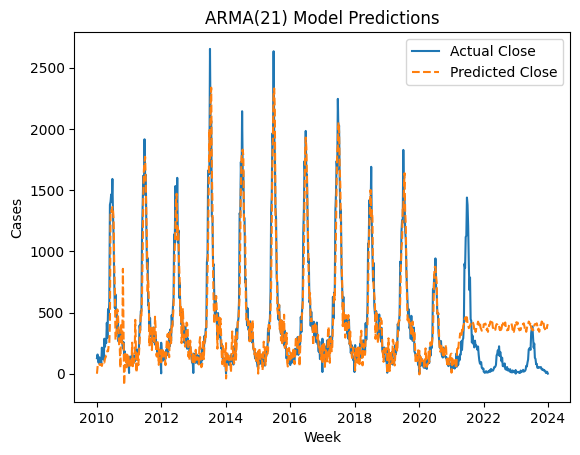

In [78]:
sarima_pred_full = results.predict(start=0, end=len(train_data) + len(test_data) - 1) # note we start at zero

plt.plot(lyme_disease_rate['Cases'], label = 'Actual Close')
plt.plot(lyme_disease_rate.index, sarima_pred_full, label = 'Predicted Close', linestyle = '--')
plt.xlabel('Week')
plt.ylabel('Cases')
plt.legend()
plt.title('ARMA(21) Model Predictions')
plt.show();